In [36]:
import numpy as np
import cv2
%matplotlib inline

from skimage import color
from skimage import io

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image


In [37]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

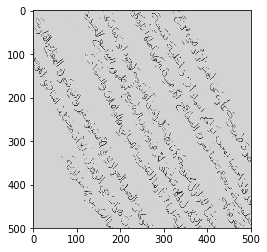

In [38]:
#Test importing and cropping image to center 

image = color.rgb2gray(mpimg.imread('data_prepared/1.png'))
plt.imshow(image, cmap='gray') # show image in grayscale

image = crop_center(image, 500, 500)
plt.imshow(image, cmap='gray') # show image in grayscale



In [39]:
def import_image_and_crop(datapath,crop_size=1000):
    ''' Read the image, convert it to grayscale, and use only the (crop_size x crop_size) center'''
    image = color.rgb2gray(mpimg.imread(datapath))
    assert(np.shape(image)[0]>crop_size and np.shape(image)[1]>crop_size),"Cant get center because image is too small"
    image = crop_center(image, crop_size, crop_size)
    return image

In [141]:
# import data

from os import listdir
from os.path import isfile, join
import random

crop_size = 138

onlyfiles = [f for f in listdir('data_prepared/') if isfile(join('data_prepared/', f))] # get list of datanames in folder

number_data = len(onlyfiles) - 1 # How many datafiles? One less because there is a list for the rotations
datanames = np.linspace(1,number_data,number_data)

X_train_pre = np.empty([number_data,crop_size,crop_size]) # create array to be filled, remember crop_size

for counter, number_of_file in enumerate(datanames):
    print(counter, end="\r")
    datapath = 'data_prepared/' + str(int(number_of_file))+'.png' # i know this is ugly
    X_train_pre[counter,:,:] = import_image_and_crop(datapath, crop_size)
    
    

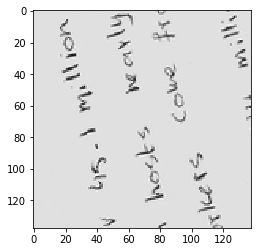

In [121]:
plt.imshow(X_train_pre[63,:,:], cmap='gray') # show image in grayscale, now squared and in the middle


In [143]:
# load angle list
Y_train_pre2 = np.loadtxt('data_prepared/angle_list.txt', delimiter=',', unpack=True)
Y_train_pre2.reshape((number_data,1))


array([[294.],
       [253.],
       [133.],
       [247.],
       [297.],
       [ 61.],
       [ 84.],
       [ 78.],
       [360.],
       [ 98.],
       [ 21.],
       [338.],
       [ 34.],
       [  9.],
       [229.],
       [271.],
       [ 81.],
       [214.],
       [103.],
       [232.],
       [ 80.],
       [ 43.],
       [187.],
       [ 50.],
       [ 98.],
       [199.],
       [166.],
       [135.],
       [203.],
       [ 91.],
       [284.],
       [232.],
       [ 65.],
       [307.],
       [112.],
       [ 77.],
       [265.],
       [120.],
       [ 75.],
       [282.],
       [341.],
       [260.],
       [ 68.],
       [337.],
       [ 10.],
       [115.],
       [173.],
       [197.],
       [162.],
       [308.],
       [161.],
       [142.],
       [ 65.],
       [110.],
       [325.],
       [221.],
       [164.],
       [  6.],
       [ 88.],
       [ 99.],
       [ 18.],
       [356.],
       [153.],
       [101.],
       [146.],
       [232.],
       [ 4

In [144]:
X_train_pre = X_train_pre.astype('float32')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_pre = scaler.fit_transform(X_train_pre.reshape(X_train_pre.shape[0],crop_size*crop_size))

np.shape(X_train_pre)

(200, 19044)

In [145]:
# own periodic loss function

def mse_periodic(y_true, y_pred):
    print(np.shape(y_true))
    diff = 180 - abs(abs(y_true - y_pred) - 180)
    return 1 * (np.sum( (diff)**2 ))


In [162]:
# weird thingy 
shape_ord = (crop_size, crop_size, 1)

X_train_pre2 = X_train_pre


X_train_pre2 = X_train_pre2.reshape((X_train_pre2.shape[0],) + shape_ord)
X_train_pre2 = X_train_pre2.astype('float32')


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

# -- Initializing the values for the convolution neural network

nb_epoch = 30  # kept very low! Please increase if you can use a GPU

batch_size = 50
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))
#model.add(Dense(1, activation='relu'))


model.compile(loss=mse_periodic, optimizer='adam')
          
model.summary()

(?, ?)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 136, 136, 32)      320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 134, 134, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 67, 67, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 67, 67, 64)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 287296)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               36774016  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
Tot

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train_pre2, Y_train_pre2, test_size=0.3, random_state=20)

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 5s 37ms/step - loss: 9625.1948 - val_loss: 11211.0116
Epoch 2/30
140/140 [==============================] - 5s 33ms/step - loss: 9448.8099 - val_loss: 11227.2345
Epoch 3/30
140/140 [==============================] - 5s 33ms/step - loss: 9463.5527 - val_loss: 11250.1004
Epoch 4/30
140/140 [==============================] - 5s 33ms/step - loss: 9401.7037 - val_loss: 11241.0088
Epoch 5/30
140/140 [==============================] - 5s 33ms/step - loss: 9403.9541 - val_loss: 11213.6058
Epoch 6/30
140/140 [==============================] - 5s 33ms/step - loss: 9410.0018 - val_loss: 11261.0127
Epoch 7/30
140/140 [==============================] - 5s 33ms/step - loss: 9208.2839 - val_loss: 11232.4622
Epoch 8/30
140/140 [==============================] - 5s 33ms/step - loss: 9108.2165 - val_loss: 11225.5623
Epoch 9/30
140/140 [==============================] - 5s 33ms/step - loss: 9038.0841 - val_

In [161]:
Y_pred = model.predict(X_train)
np.max(Y_pred)

32.13031